In [2]:
import nba_py
from nba_py import game, player, team, constants
from datetime import date, timedelta

import pandas as pd
pd.set_option('display.max_columns', 500)

import plotly.plotly as py
import plotly.graph_objs as go 
import plotly.colors as pc
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(True)

In [3]:
def boxScoresFromDay(day):
    dfs = []
    nbaDay = nba_py.Scoreboard(month=day.month, day=day.day, year=day.year)
    # if we requested a bad date, return empty list
    if nbaDay.line_score().empty: return []
    gameIds = nbaDay.line_score().GAME_ID.unique()
    for gID in gameIds:
        summary = game.BoxscoreSummary(gID).game_summary()
        
        # for now, only add metadata about home/away team. can add more metadata later
        home_id = summary.HOME_TEAM_ID.values[0]
        player_bs = game.Boxscore(gID).player_stats()
        player_bs['Home'] = player_bs.TEAM_ID == home_id
        
        # only include players who played in this game
        ps = player_bs.loc[~player_bs.COMMENT.str.startswith('DNP', na=False)].copy()
        ps['gameScore'] = ps.PTS + 0.4* ps.FGM - 0.7 * ps.FGA - 0.4 * (ps.FTA - ps.FTM) + \
                  0.7 * ps.OREB + 0.3 * ps.DREB + ps.STL + 0.7 * ps.AST + \
                  0.7 * ps.BLK - 0.4 * ps.PF - ps.TO
        ps['Season'] = day.year
        dfs += [ps]
    return dfs

In [4]:
yrs = [
    2014,
    2015,
    2016,
]
playoffDates = [
    (4, 18), 
    (4, 16), 
    (4, 15)
]

regSeason = {}
playoffs = {}
stDate = lambda yr: date(yr, 10, 1)
endDate = lambda yr: date(yr + 1, 6, 30)

for yr, (mon, day) in zip(yrs, playoffDates):
    playoffStart = date(yr + 1, mon, day)
    delta = playoffStart - stDate(yr)
    regSeason[yr] = [stDate(yr) + timedelta(i)
                     for i in range(delta.days + 1)]
    playoffs[yr] = [playoffStart + timedelta(i)
                    for i in range((endDate(yr) - playoffStart).days + 1)]
    

In [ ]:
playoff_bs = {}
for k, v in playoffs.items():
    playoff_bs[k] = []
    for day in v:
        playoff_bs[k] += boxScoresFromDay(day)
    playoff_bs[k] = pd.concat(playoff_bs[k], axis=0)
    
# for now, use reg season data from Kaggle
# reg_bs = {}
# for k, v in regSeason.items():
#     reg_bs[k] = []
#     for day in v:
#         reg_bs[k] += boxScoresFromDay(day)
#     reg_bs[k] = pd.concat(reg_bs[k], axis=0)
    
# reg_bs[2016]

In [ ]:
playoff_bs[2014]

In [70]:
ps = pd.read_csv('playerscores2016.csv')  # 2017 player box scores
bs = pd.read_csv('boxscores2016.csv')  # 2017 team box scores
# calculate game score
ps['gameScore'] = ps.playPTS + 0.4* ps.playFGM - 0.7 * ps.playFGA - 0.4 * (ps.playFTA - ps.playFTM) + \
                  0.7 * ps.playORB + 0.3 * ps.playDRB + ps.playSTL + 0.7 * ps.playAST + \
                  0.7 * ps.playBLK - 0.4 * ps.playPF - ps.playTO

ptgCnt = ps[['gmDate', 'teamAbbr', 'playDispNm']]\
                    .groupby(['teamAbbr', 'playDispNm'], as_index=False).count()
noTeams = ptgCnt.groupby(['playDispNm'], as_index=False).count()  
traded = noTeams.loc[noTeams.gmDate > 1]  # traded players, ignore for now

gsAvgs = ps[['gameScore', 'teamAbbr', 'playDispNm']]\
                    .groupby(['teamAbbr', 'playDispNm'], as_index=False).mean()
gsAvgs['rank'] = gsAvgs.groupby(['teamAbbr'])['gameScore'].rank(ascending=False)
pLocAvgs = ps[['gameScore', 'teamAbbr', 'playDispNm', 'teamLoc']]\
                    .groupby(['teamAbbr', 'playDispNm', 'teamLoc'], as_index=False).mean()
rankGS = pd.merge(pLocAvgs, gsAvgs, on=['teamAbbr', 'playDispNm'], suffixes=('_loc', '_avg'))

rankGS['locLift'] = (rankGS.gameScore_loc - rankGS.gameScore_avg)*100.0/rankGS.gameScore_avg

maxRank = 14
rankGS = rankGS.loc[(rankGS.gameScore_avg > 0) & (rankGS.gameScore_loc > 0) & (rankGS['rank'] < maxRank)]

rankGS.head()
        

,teamAbbr,playDispNm,teamLoc,gameScore_loc,gameScore_avg,rank,locLift
2,ATL,Dennis Schröder,Away,12.658974,12.396203,3.0,2.119777
3,ATL,Dennis Schröder,Home,12.140000,12.396203,3.0,-2.066782
4,ATL,Dwight Howard,Away,13.517143,13.498649,2.0,0.137008
5,ATL,Dwight Howard,Home,13.482051,13.498649,2.0,-0.122956
7,ATL,Ersan Ilyasova,Away,6.058333,7.784615,5.0,-22.175560


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e257d30>]], dtype=object)

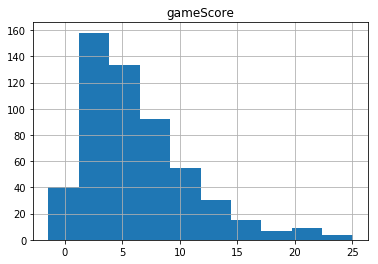

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
gsAvgs.hist(column='gameScore')


In [99]:

trace1 = go.Histogram(
    x=gsAvgs.gameScore,
    histnorm='count',
    name='control',
    xbins=dict(
        start=0.0,
        end=25.0,
        size=1.25
    ),
    marker=dict(
        color='#0000FF',
    ),
    opacity=0.75
)

data = [trace1]

layout = go.Layout(
    title='Histogram of Average Player Game Score',
    xaxis=dict(
        title='Game Score'
    ),
    yaxis=dict(
        title='Number of Players'
    ),
    bargap=0,
    bargroupgap=0.05
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='styled histogram')

In [113]:

gsByRank = gsAvgs.groupby(['rank'], as_index=False).mean()
gsByRank = gsByRank.loc[gsByRank['rank'] < 15]

data = [go.Bar(
            x=gsByRank['rank'],
            y=gsByRank.gameScore,
            marker=dict(
                    color='#0000FF',
                ),
    )]

layout = go.Layout(
    title='Average Game Score by Rank within Team',
    xaxis=dict(
        title='Rank within Team'
    ),
    yaxis=dict(
        title='Game Score'
    ),
    bargap=0,
    bargroupgap=0.05
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='basic-bar')

In [76]:
teams = ps.teamAbbr.unique()
traces = []
colors = pc.DEFAULT_PLOTLY_COLORS
homeGS = rankGS.loc[rankGS.teamLoc == 'Home'].sort_values('rank')

for i, team in list(enumerate(teams)):
    traces += [go.Scatter(
                x=homeGS.loc[homeGS.teamAbbr == team, 'rank'],
                y=homeGS.loc[homeGS.teamAbbr == team, 'locLift'],
                name=team,
                text=homeGS.loc[homeGS.teamAbbr == team, 'playDispNm'],
                visible=True,
                opacity = 0.15,
                marker=dict(color = colors[i%len(colors)]),
                hoverinfo='none'
                          )
              ] 
    
leagueAvg = homeGS.groupby(['rank'], as_index=False)['locLift'].mean()

traces += [go.Scatter(
            x=leagueAvg['rank'],
            y=leagueAvg['locLift'],
            name='League Avg Lift',
            visible=True,
            opacity = 1,
            marker=dict(color = 'rgb(0,0,0)')
                      )
          ] 

layout = dict(
    title='Home Game Score Lift as a League Average', 
    showlegend=False,
    xaxis=dict(
        title='Rank within team by Average Game Score'
               ),
    yaxis=dict(
        title='% Lift in Game Score Average at Home'
               ),    
              )

fig = dict(data=traces, layout=layout)


py.iplot(fig, filename='GmSc League')

In [77]:
teams = ps.teamAbbr.unique()
traces = []
colors = pc.DEFAULT_PLOTLY_COLORS
homeGS = rankGS.loc[rankGS.teamLoc == 'Home'].sort_values('rank')

for i, team in list(enumerate(teams)):
    traces += [go.Scatter(
                x=homeGS.loc[homeGS.teamAbbr == team, 'rank'],
                y=homeGS.loc[homeGS.teamAbbr == team, 'locLift'],
                name=team,
                text=homeGS.loc[homeGS.teamAbbr == team, 'playDispNm'],
                visible=True,
                opacity = 1,
                marker=dict(color = colors[i%len(colors)])
                          )
              ] 
    

buttons = []

for i, team in list(enumerate(teams)):
    buttons += [dict(label = team,
                 method = 'update',
                 args = [{'visible': [(n%30) == i for n in range(60)]},
                         {'title': "%s's Home GmSc lift by rank in team" % team},
                         {'opacity': [0.9 for n in range(60)]}
                         ])]
    
buttons += [dict(label = 'Reset',
                 method = 'update',
                 args = [{'visible': [True for n in range(60)]},
                         {'title': "Home Game Score lift by rank in team"},
                         ]
                )]

updatemenus = list([
    dict(active=-1,
         buttons=buttons,
    )
])


layout = dict(
    title='Home Game Score Lift as a league Average', 
    showlegend=False,
    xaxis=dict(
        title='Rank within team by Average Game Score'
               ),
    yaxis=dict(
        title='% Lift in Game Score Average at Home'
               ),        
    updatemenus=updatemenus
              )
fig = dict(data=traces, layout=layout)
py.iplot(fig, filename='GmSc by team')

In [114]:
gsAvgs = gsAvgs.loc[gsAvgs['rank'] < 15]

,teamAbbr,playDispNm,gameScore,rank
0,ATL,DeAndre’ Bembry,2.050000,15.0
1,ATL,Dennis Schröder,12.396203,3.0
2,ATL,Dwight Howard,13.498649,2.0
3,ATL,Edy Tavares,1.200000,18.0
4,ATL,Ersan Ilyasova,7.784615,5.0
5,ATL,Gary Neal,-0.150000,20.0
6,ATL,Jose Calderon,3.035294,14.0
7,ATL,Kent Bazemore,7.443836,6.0
8,ATL,Kris Humphries,3.821429,12.0
9,ATL,Kyle Korver,7.159375,7.0


In [116]:
py = playoff_bs[2016]

In [122]:
# ptgCnt = ps[['gmDate', 'teamAbbr', 'playDispNm']]\
#                     .groupby(['teamAbbr', 'playDispNm'], as_index=False).count()
# noTeams = ptgCnt.groupby(['playDispNm'], as_index=False).count()  
# traded = noTeams.loc[noTeams.gmDate > 1]  # traded players, ignore for now

pyAvgs = py[['gameScore', 'TEAM_ABBREVIATION', 'PLAYER_NAME']]\
                    .groupby(['TEAM_ABBREVIATION', 'PLAYER_NAME'], as_index=False).mean()
pyAvgs['rank'] = pyAvgs.groupby(['TEAM_ABBREVIATION'])['gameScore'].rank(ascending=False)

pyAvgs.columns = ['teamAbbr', 'playDispNm', 'gameScore', 'rank']

In [123]:
pyAvgs

,teamAbbr,playDispNm,gameScore,rank
0,ATL,Dennis Schroder,19.166667,1.0
1,ATL,Dwight Howard,8.216667,4.0
2,ATL,Ersan Ilyasova,3.300000,9.0
3,ATL,Jose Calderon,3.616667,8.0
4,ATL,Kent Bazemore,6.116667,6.0
5,ATL,Kris Humphries,0.700000,12.0
6,ATL,Malcolm Delaney,7.000000,5.0
7,ATL,Mike Dunleavy,0.900000,11.0
8,ATL,Mike Muscala,1.983333,10.0
9,ATL,Paul Millsap,18.916667,2.0


In [125]:
playGS = pd.merge(gsAvgs, pyAvgs, on=['teamAbbr', 'playDispNm'], suffixes=('_reg', '_ply'))


In [127]:
playGS['playDiff'] = (playGS.gameScore_ply - playGS.gameScore_reg)*100.0/playGS.gameScore_reg

In [134]:
playGS.sort_values(['teamAbbr', 'rank_reg'])

,teamAbbr,playDispNm,gameScore_reg,rank_reg,gameScore_ply,rank_ply,playDiff
8,ATL,Paul Millsap,14.186957,1.0,18.916667,2.0,33.338441
0,ATL,Dwight Howard,13.498649,2.0,8.216667,4.0,-39.129709
11,ATL,Tim Hardaway Jr.,9.846835,4.0,4.383333,7.0,-55.484852
1,ATL,Ersan Ilyasova,7.784615,5.0,3.300000,9.0,-57.608696
3,ATL,Kent Bazemore,7.443836,6.0,6.116667,6.0,-17.829101
10,ATL,Thabo Sefolosha,6.812903,8.0,-0.325000,13.0,-104.770360
7,ATL,Mike Muscala,5.667143,9.0,1.983333,10.0,-65.002941
6,ATL,Mike Dunleavy,4.376667,10.0,0.900000,11.0,-79.436405
9,ATL,Taurean Prince,3.866102,11.0,8.716667,3.0,125.463978
4,ATL,Kris Humphries,3.821429,12.0,0.700000,12.0,-81.682243


In [137]:
teams = ps.teamAbbr.unique()
traces = []
colors = pc.DEFAULT_PLOTLY_COLORS
playGS = playGS.sort_values(['teamAbbr', 'rank_reg'])

for i, team in list(enumerate(teams)):
    traces += [go.Scatter(
                x=playGS.loc[playGS.teamAbbr == team, 'rank_reg'],
                y=playGS.loc[playGS.teamAbbr == team, 'playDiff'],
                name=team,
                text=playGS.loc[playGS.teamAbbr == team, 'playDispNm'],
                visible=True,
                opacity = 0.15,
                marker=dict(color = colors[i%len(colors)]),
                hoverinfo='none'
                          )
              ] 
    
leagueAvg = playGS.groupby(['rank_reg'], as_index=False)['playDiff'].mean()

traces += [go.Scatter(
            x=leagueAvg['rank_reg'],
            y=leagueAvg['playDiff'],
            name='Playoff Avg Lift',
            visible=True,
            opacity = 1,
            marker=dict(color = 'rgb(0,0,0)')
                      )
          ] 

layout = dict(
    title='Playoff Game Score Lift as a League Average', 
    showlegend=False,
    xaxis=dict(
        title='Rank within team by Average Game Score'
               ),
    yaxis=dict(
        title='% Lift in Game Score Average during Playoffs'
               ),    
              )

fig = dict(data=traces, layout=layout)


iplot(fig, filename='GmSc League')